In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

In [114]:
# Load data
stocks = pd.read_csv('./stock_data_inputs.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.sort_values('Date', inplace=True)

features = stocks[['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA']]
target = stocks['Percent_Change']

In [115]:
scaler = MinMaxScaler()
feature_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

In [77]:
def create_sequences(input_data, output_data, window):
    X, y = [], []
    for i in range(len(input_data) - window):
        X.append(input_data[i:(i + window)])
        y.append(output_data[i + window])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(feature_scaled, target_scaled, window_size)

In [116]:
# A mixture from https://github.com/you915/Sentiment-Analysis-of-Twitter-Data-for-predicting-Apple-stock-price and https://github.com/thomasjv799/Stock-Market-Prediction-using-LSTM-and-tweets/blob/main/lstm_tweet.ipynb
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_columns, target_column):
    X = []
    y = []
    for i in range(len(df) - window):
        # Extract features and target from the dataframe, and append them to the lists
        features = df.iloc[i:(i + window), feature_columns].values
        target = df.iloc[i + window, target_column]
        X.append(features)
        y.append(target)
        
    return np.array(X), np.array(y).reshape(-1, 1)

# Example usage:
# Assuming 'stocks' is your dataframe and the feature and target columns are specified by indices
feature_col_indices = [stocks.columns.get_loc(col) for col in ['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA']]
target_col_index = stocks.columns.get_loc('Percent_Change')

window_size = 10  # Define your window size
X, y = window_data(stocks, window_size, feature_col_indices, target_col_index)

In [117]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [118]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 4))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 4))

In [119]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 4)),
    Dropout(0.3),
    LSTM(50, return_sequences=True),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 10, 50)            11000     
                                                                 
 dropout_25 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_34 (LSTM)              (None, 10, 50)            20200     
                                                                 
 dropout_26 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_35 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_27 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1)               

In [120]:
history = model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, validation_split=0.1)

Epoch 1/50
4/4 [==============================] - 4s 251ms/step - loss: 3.2348 - val_loss: 0.6745
Epoch 2/50
4/4 [==============================] - 0s 12ms/step - loss: 3.3064 - val_loss: 0.7332
Epoch 3/50
4/4 [==============================] - 0s 12ms/step - loss: 2.9728 - val_loss: 0.7935
Epoch 4/50
4/4 [==============================] - 0s 12ms/step - loss: 3.0461 - val_loss: 0.7988
Epoch 5/50
4/4 [==============================] - 0s 12ms/step - loss: 3.1313 - val_loss: 0.7223
Epoch 6/50
4/4 [==============================] - 0s 12ms/step - loss: 2.9414 - val_loss: 0.7327
Epoch 7/50
4/4 [==============================] - 0s 12ms/step - loss: 3.0334 - val_loss: 0.7523
Epoch 8/50
4/4 [==============================] - 0s 12ms/step - loss: 2.9640 - val_loss: 0.7675
Epoch 9/50
4/4 [==============================] - 0s 12ms/step - loss: 2.9075 - val_loss: 0.7640
Epoch 10/50
4/4 [==============================] - 0s 12ms/step - loss: 2.6821 - val_loss: 0.7887
Epoch 11/50
4/4 [===========

In [121]:
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

1/1 [==============================] - 1s 726ms/step
Root Mean Squared Error: 1.1964888935463298
R-squared: -0.6072996218622218


In [122]:
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

results = pd.DataFrame({
    'Real': real_prices.ravel(),
    'Predicted': predicted_prices.ravel()
})

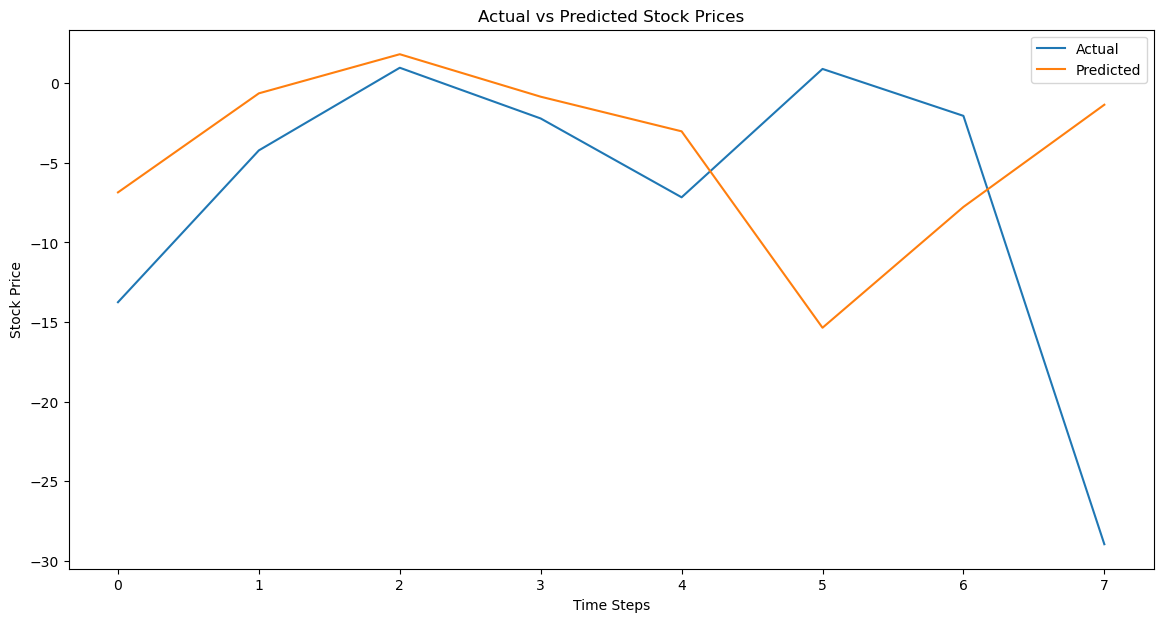

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(results['Real'], label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

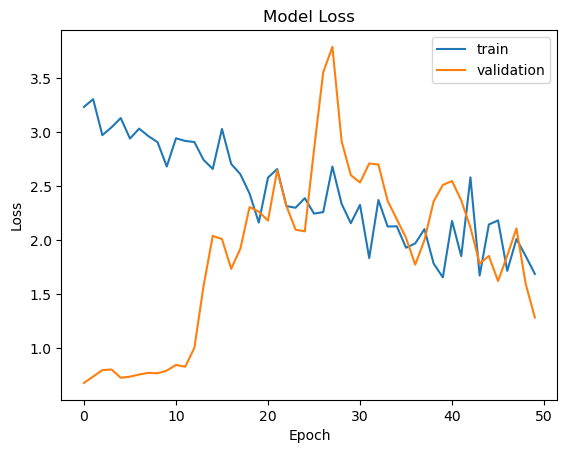

In [124]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()